/ihome/jbwang/liy121/ifimage/evaluation_core.py:99: UserWarning: cyto_prediction_refined: 2 predictions had no GT (e.g., ['pecam_15971', 'pecam_15972']).
  warnings.warn(f"{pred_dir.name}: {len(missing_gt)} predictions had no GT (e.g., {missing_gt[:3]}).")


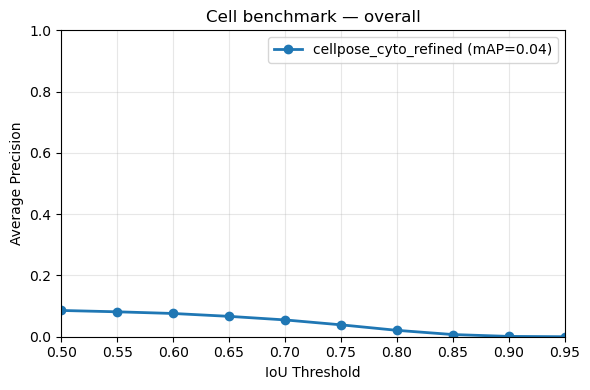

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from evaluation_tasks import evaluate_cell_benchmark  # or evaluate_nuclei_benchmark

# 1) Choose IoU thresholds for COCO-style mAP
thr = np.arange(0.50, 0.96, 0.05)                # 0.50 → 0.95 step 0.05
ap_cols = [f"AP@{t:.2f}" for t in thr]           # column names expected in per-image DF

# 2) Run evaluation (cells example). For nuclei, call evaluate_nuclei_benchmark.
cyto_preds = {
    "cellpose_cyto_refined": Path("01_cellpose_benchmark/cyto_prediction_refined"),
    # add more algos here...
}





per_img_cyto, sum_cyto = evaluate_cell_benchmark(
    dataset_dir="00_dataset",
    cyto_pred_dirs=cyto_preds,
    ap_thresholds=tuple(np.round(thr, 2)),       # make sure we evaluate exactly these thresholds
    boundary_scales=(1.0, 2.0),                  # tweak if you like
)

# 3) Average AP across images to get the curve per algorithm; compute mAP (mean over thresholds)
curve = per_img_cyto.groupby("algorithm")[ap_cols].mean()     # rows: algo, cols: AP@τ
mAP = curve.mean(axis=1)                                      # mean over columns (IoU thresholds)

# 4) Single-panel plot (overall)
plt.figure(figsize=(6, 4))
for algo, row in curve.iterrows():
    plt.plot(thr, row.values, marker='o', linewidth=2,
             label=f"{algo} (mAP={mAP[algo]:.02f})")
plt.title("Cell benchmark — overall")
plt.xlabel("IoU Threshold")
plt.ylabel("Average Precision")
plt.xlim(0.5, 0.95)
plt.ylim(0, 1.0)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


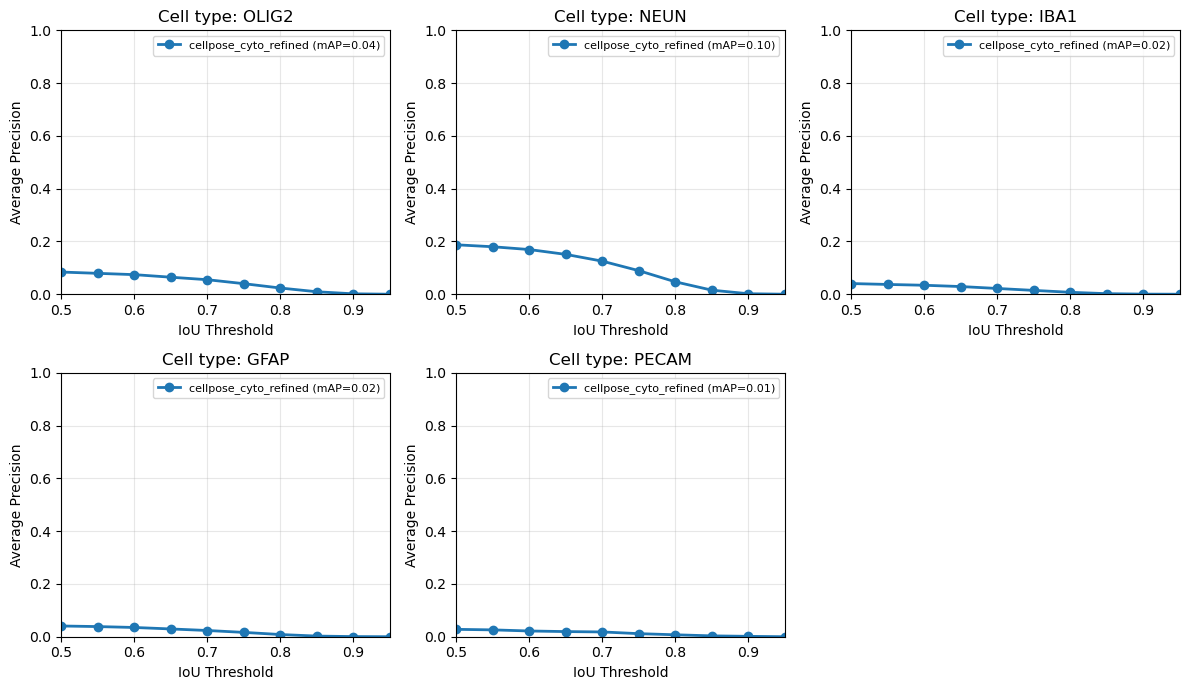

In [3]:
import math
# Map panel name -> regex to select images by `base` column
groups = {
    "OLIG2": r"OLIG2",
    "NEUN":  r"NEUN",
    "IBA1":  r"IBA1",
    "GFAP":  r"GFAP",
    "PECAM": r"PECAM",
}

ncols = 3
nrows = math.ceil(len(groups) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 7), squeeze=False)

for ax, (gname, pattern) in zip(axes.ravel(), groups.items()):
    sub = per_img_cyto[per_img_cyto["base"].str.contains(pattern, case=False, regex=True)]
    if sub.empty:
        ax.set_title(f"Cell type: {gname} (no images)")
        ax.axis("off")
        continue

    grp_curve = sub.groupby("algorithm")[ap_cols].mean()
    grp_mAP = grp_curve.mean(axis=1)

    for algo, row in grp_curve.iterrows():
        ax.plot(thr, row.values, marker='o', linewidth=2,
                label=f"{algo} (mAP={grp_mAP[algo]:.02f})")

    ax.set_title(f"Cell type: {gname}")
    ax.set_xlabel("IoU Threshold")
    ax.set_ylabel("Average Precision")
    ax.set_xlim(0.5, 0.95)
    ax.set_ylim(0, 1.0)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)

# hide any unused axes
for j in range(len(groups), nrows*ncols):
    axes.ravel()[j].axis("off")

plt.tight_layout()
plt.show()


# Eva

In [57]:
# All comments in ENGLISH
from pathlib import Path
from evaluation_core import EvalConfig, evaluate_all
import numpy as np

# If your prediction subfolder is spelled "nuiclei_prediction" (typo),
# keep it consistent across all four methods here.
PRED_SUBDIR = "nuclei_prediction"   # change to "nuclei_prediction" ONLY if your folders are named that way

pred_dirs = {
    "cellpose": Path(f"01_cellpose_benchmark/{PRED_SUBDIR}"),
    "stardist": Path(f"02_stardist_benchmark/{PRED_SUBDIR}"),
    #"cellsam":  Path(f"03_cellsam_benchmark/{PRED_SUBDIR}"),
    "mesmer":   Path(f"04_mesmer_benchmark/{PRED_SUBDIR}"),
}

# Put longer tokens before shorter ones to avoid partial stripping (e.g., "_pred_nuclei" before "_nuc").
pred_strip = {
    "cellpose": [
        "_cp_masks", "_cp_mask",
        "_labels", "_label",
        "_masks", "_mask",
        "_pred_nuclei", "_pred_nuc",
        "_prediction", "_refined", "_filtered", "_filter",
        "_nuclei", "_nuc",
    ],
    "stardist": [
        "_stardist_nuclei", "_stardist_nuc", "_stardist",
        "_pred_nuclei", "_pred_nuc",
        "_prediction", "_refined", "_filtered", "_filter",
        "_nuclei", "_nuc",
    ],
    # "cellsam": [
    #     "_cellsam", "_sam",
    #     "_masks", "_mask", "_labels", "_label",
    #     "_pred_nuclei", "_pred_nuc",
    #     "_prediction", "_refined", "_filtered", "_filter",
    #     "_nuclei", "_nuc",
    # ],
    "mesmer": [
        "_pred_nuclei", "_pred_nuc",
        "_prediction", "_refined", "_filtered", "_filter",
        "_nuclei", "_nuc",
        "_mesmer",
    ],
}

cfg = EvalConfig(
    gt_dir=Path("00_dataset"),
    pred_dirs=pred_dirs,
    gt_glob="*_dapimultimask.npy",
    pred_glob="*.npy",
    gt_strip=["_dapimultimask"],
    pred_strip=pred_strip,  # IMPORTANT: keys must match pred_dirs
    ap_thresholds=tuple(np.round(np.arange(0.50, 0.96, 0.05), 2)),
    boundary_scales=(1.0, 2.0),
)

per_img_nuc, sum_nuc = evaluate_all(cfg)

evaluation_core.py (109): nuclei_prediction: 90 predictions had no GT (e.g., ['gfap_3527', 'gfap_3532', 'gfap_3569']).
evaluation_core.py (109): nuclei_prediction: 90 predictions had no GT (e.g., ['gfap_3527', 'gfap_3532', 'gfap_3569']).
evaluation_core.py (109): nuclei_prediction: 90 predictions had no GT (e.g., ['gfap_3527', 'gfap_3532', 'gfap_3569']).


In [58]:
# All comments in ENGLISH
import pandas as pd

if isinstance(per_img_nuc, pd.DataFrame):
    print("unique algorithms:", sorted(per_img_nuc["algorithm"].unique()))
    print(per_img_nuc["algorithm"].value_counts())
else:
    # If evaluate_all returned a dict instead of a DataFrame
    print("keys (algorithms):", list(per_img_nuc.keys()))


unique algorithms: ['cellpose', 'mesmer', 'stardist']
algorithm
cellpose    37
stardist    37
mesmer      37
Name: count, dtype: int64


In [59]:
# All comments in ENGLISH
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _as_perimg_df(per_img):
    """
    Accept either:
      - dict: {algo_name: per-image DataFrame}, OR
      - DataFrame: with or without 'algorithm' column.
    Return a single DataFrame with an 'algorithm' column.
    """
    if isinstance(per_img, dict):
        parts = []
        for algo, df in per_img.items():
            if df is None or len(df) == 0:
                continue
            df = df.copy()
            if "algorithm" not in df.columns:
                df["algorithm"] = algo
            else:
                # ensure the algorithm column actually says the dict key
                df["algorithm"] = algo
            parts.append(df)
        return pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    elif isinstance(per_img, pd.DataFrame):
        df = per_img.copy()
        if "algorithm" not in df.columns:
            df["algorithm"] = "model"
        return df
    else:
        raise TypeError("per_img must be a dict[str, DataFrame] or a DataFrame.")

def _infer_ap_cols(df):
    """
    Find AP columns named like 'AP@0.50', 'AP@0.55', ...
    Return (thr_array, ordered_ap_cols).
    """
    ap_cols = [c for c in df.columns if re.match(r"^AP@\d\.\d{2}$", c)]
    if not ap_cols:
        raise ValueError("No AP@xx.xx columns found in per-image table.")
    thr = np.array([float(c.split("@")[1]) for c in ap_cols], dtype=float)
    order = np.argsort(thr)
    thr = thr[order]
    ap_cols = [ap_cols[i] for i in order]
    return thr, ap_cols

def plot_ap_curves_multi(per_img, out_png: Path = None, title: str = "Nuclei benchmark — overall", dpi: int = 300):
    """
    Build AP curves per algorithm and plot multiple lines.
    Also compute mAP (mean over thresholds) per algorithm.
    Returns (curve_df, mAP_series).
    """
    df = _as_perimg_df(per_img)
    if df.empty:
        print("No matched GT/prediction pairs. Check filename pairing (gt_strip/pred_strip).")
        return None, None

    thr, ap_cols = _infer_ap_cols(df)

    # Safety check: ensure all AP columns exist
    missing = [c for c in ap_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing AP columns: {missing}")

    # Mean across images per algorithm -> AP curve matrix
    curve = df.groupby("algorithm", sort=True)[ap_cols].mean()
    mAP = curve.mean(axis=1)

    # Plot curves
    plt.figure(figsize=(7, 5))
    for algo, row in curve.iterrows():
        plt.plot(thr, row.values, marker="o", linewidth=2, label=f"{algo} (mAP={mAP[algo]:.02f})")
    plt.title(title)
    plt.xlabel("IoU Threshold")
    plt.ylabel("Average Precision")
    plt.xlim(thr.min(), thr.max())
    plt.ylim(0.0, 1.0)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if out_png is not None:
        out_png.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_png, dpi=dpi, bbox_inches="tight", pad_inches=0.02)
        print(f"Saved curve figure -> {out_png}")
    plt.show()

    return curve, mAP

def plot_map_bars(mAP, out_png: Path = None, dpi: int = 300, title: str = "mAP (mean over IoU thresholds)"):
    """
    Plot a simple bar chart for per-algorithm mAP.
    """
    if mAP is None or len(mAP) == 0:
        print("Empty mAP; nothing to plot.")
        return
    mAP = mAP.sort_values(ascending=False)
    plt.figure(figsize=(6, 4))
    mAP.plot(kind="bar")
    plt.ylabel("mAP")
    plt.ylim(0.0, 1.0)
    plt.title(title)
    plt.tight_layout()
    if out_png is not None:
        out_png.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_png, dpi=dpi, bbox_inches="tight", pad_inches=0.02)
        print(f"Saved mAP bars -> {out_png}")
    plt.show()


Saved curve figure -> plots/nuclei_overall_ap.png


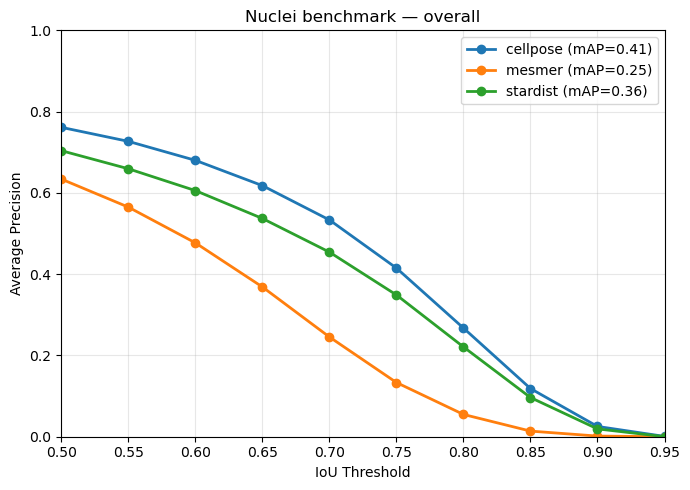

Saved mAP bars -> plots/nuclei_mAP.png


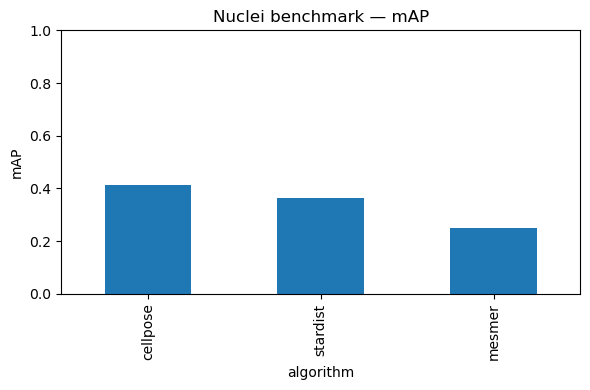

In [60]:

# per_img_nuc can be a dict of DataFrames OR a single DataFrame.
curve, mAP = plot_ap_curves_multi(
    per_img=per_img_nuc,
    out_png=Path("plots/nuclei_overall_ap.png"),
    title="Nuclei benchmark — overall",
    dpi=400,
)

# Optional: bar chart of mAP per algorithm
plot_map_bars(
    mAP,
    out_png=Path("plots/nuclei_mAP.png"),
    dpi=400,
    title="Nuclei benchmark — mAP",
)


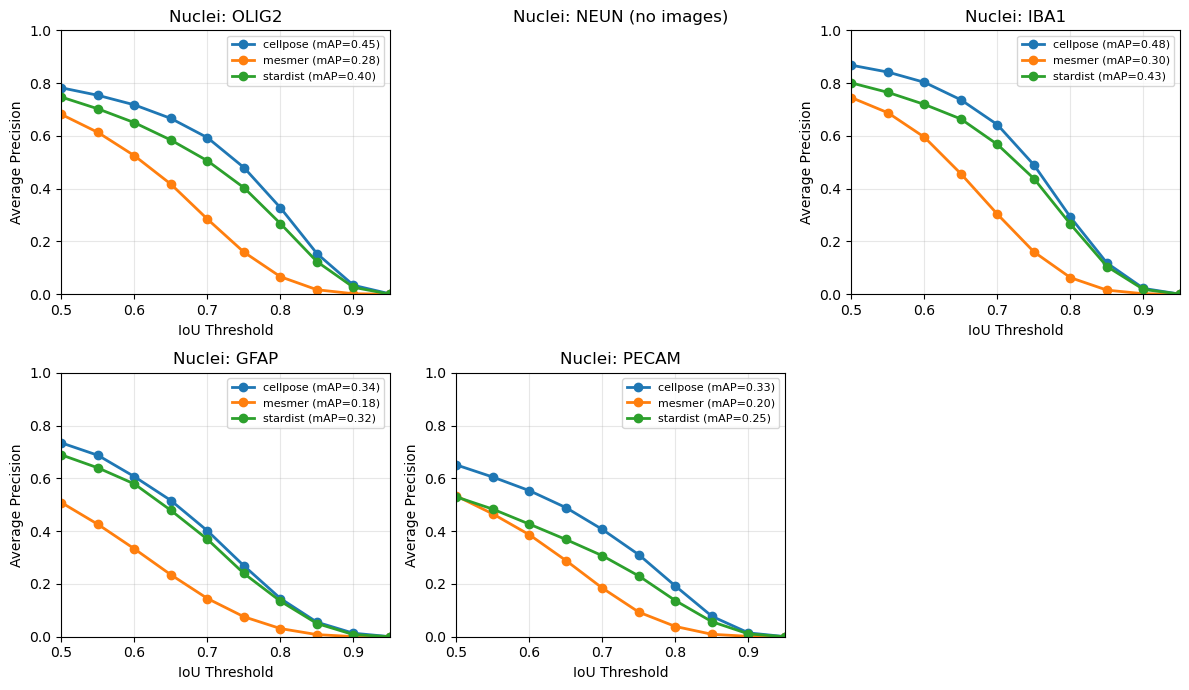

In [61]:
# Nuclei benchmark: AP-vs-IoU curves per group (facet plot)
import numpy as np
import matplotlib.pyplot as plt
import math

# If you didn't define these earlier:
if 'thr' not in globals():
    thr = np.arange(0.50, 0.96, 0.05)
if 'ap_cols' not in globals():
    ap_cols = [f"AP@{t:.2f}" for t in thr]

# Panel name -> regex over the `base` column (adjust to your naming if needed)
groups = {
    "OLIG2": r"OLIG2",
    "NEUN":  r"NEUN",
    "IBA1":  r"IBA1",
    "GFAP":  r"GFAP",
    "PECAM": r"PECAM",
}

# Safety checks
if per_img_nuc.empty:
    raise ValueError("per_img_nuc is empty (no matched GT/pred pairs). Check pairing rules.")
missing_cols = [c for c in ap_cols if c not in per_img_nuc.columns]
if missing_cols:
    raise ValueError(f"Missing AP columns: {missing_cols}. Ensure ap_thresholds={tuple(np.round(thr,2))}.")

# Layout
ncols = 3
nrows = math.ceil(len(groups) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 7), squeeze=False)

# Draw each facet
for ax, (gname, pattern) in zip(axes.ravel(), groups.items()):
    sub = per_img_nuc[per_img_nuc["base"].str.contains(pattern, case=False, regex=True, na=False)]
    if sub.empty:
        ax.set_title(f"Nuclei: {gname} (no images)")
        ax.axis("off")
        continue

    grp_curve = sub.groupby("algorithm")[ap_cols].mean()   # mean AP curve across images
    grp_mAP = grp_curve.mean(axis=1)                       # mAP = mean across IoU thresholds

    for algo, row in grp_curve.iterrows():
        ax.plot(thr, row.values, marker='o', linewidth=2,
                label=f"{algo} (mAP={grp_mAP[algo]:.02f})")

    ax.set_title(f"Nuclei: {gname}")
    ax.set_xlabel("IoU Threshold")
    ax.set_ylabel("Average Precision")
    ax.set_xlim(0.5, 0.95)
    ax.set_ylim(0, 1.0)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)

# Hide any unused axes
for ax in axes.ravel()[len(groups):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [42]:
np.load("04_mesmer_benchmark/nuiclei_prediction/pecam_15973_pred_nuclei.npy").shape

(1040, 1388)